<a href="https://colab.research.google.com/github/shuyaguan/0826/blob/main/Shuya_Guan_DL_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools
from google.colab import drive

drive.mount('/content/drive')

!wget -q https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
!unzip -q EuroSAT_RGB.zip

!ls -la
!ls -la EuroSAT_RGB/

Mounted at /content/drive
total 92468
drwxr-xr-x  1 root root     4096 Apr  9 18:54 .
drwxr-xr-x  1 root root     4096 Apr  9 18:53 ..
drwxr-xr-x  4 root root     4096 Apr  8 13:37 .config
drwx------  6 root root     4096 Apr  9 18:54 drive
drwxr-xr-x 12 root root     4096 Mar  9  2023 EuroSAT_RGB
-rw-r--r--  1 root root 94658721 Apr  9 18:54 EuroSAT_RGB.zip
drwxr-xr-x  1 root root     4096 Apr  8 13:37 sample_data
total 1128
drwxr-xr-x 12 root root   4096 Mar  9  2023 .
drwxr-xr-x  1 root root   4096 Apr  9 18:54 ..
drwxr-xr-x  2 root root 135168 Sep 18  2018 AnnualCrop
drwxr-xr-x  2 root root 114688 Sep 18  2018 Forest
drwxr-xr-x  2 root root 167936 Sep 18  2018 HerbaceousVegetation
drwxr-xr-x  2 root root  81920 Sep 18  2018 Highway
drwxr-xr-x  2 root root 110592 Sep 18  2018 Industrial
drwxr-xr-x  2 root root  69632 Sep 18  2018 Pasture
drwxr-xr-x  2 root root 118784 Sep 18  2018 PermanentCrop
drwxr-xr-x  2 root root 135168 Sep 18  2018 Residential
drwxr-xr-x  2 root root  94208 Se

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

data_dir = 'EuroSAT_RGB'
class_names = sorted(os.listdir(data_dir))
print("Classes:", class_names)
label_to_idx = {label: idx for idx, label in enumerate(class_names)}
print("Label to index mapping:", label_to_idx)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Label to index mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [3]:
def load_images(data_dir, img_size=(64, 64)):
    images = []
    labels = []
    gray_images = []

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        class_idx = label_to_idx[class_name]

        print(f"Loading {class_name} images...")
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            # Read RGB image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)

            # Create grayscale image
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Normalize
            img = img / 255.0
            gray_img = gray_img / 255.0

            images.append(img)
            gray_images.append(gray_img)
            labels.append(class_idx)

    return np.array(images), np.array(gray_images), np.array(labels)

print("Loading images...")
images, gray_images, labels = load_images(data_dir)
print(f"Loaded {len(images)} images")

Loading images...
Loading AnnualCrop images...
Loading Forest images...
Loading HerbaceousVegetation images...
Loading Highway images...
Loading Industrial images...
Loading Pasture images...
Loading PermanentCrop images...
Loading Residential images...
Loading River images...
Loading SeaLake images...
Loaded 27000 images


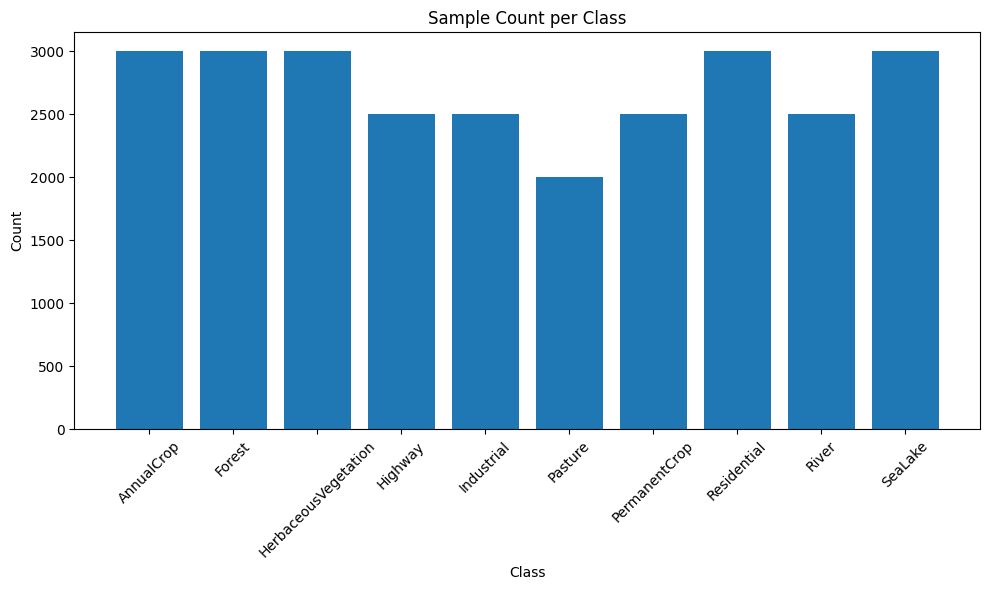

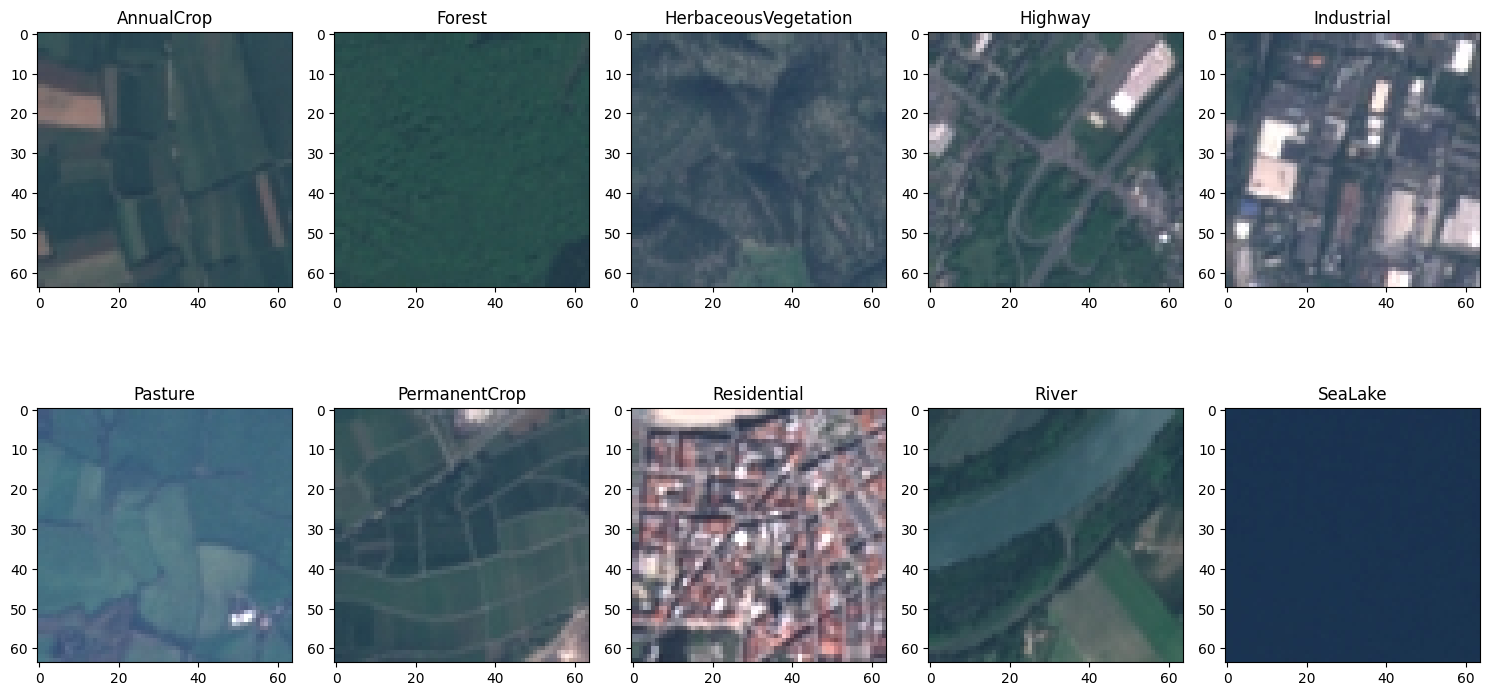

In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar([class_names[i] for i in unique_labels], counts)
plt.xticks(rotation=45)
plt.title('Sample Count per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
for i, class_idx in enumerate(unique_labels):
    class_name = class_names[class_idx]
    class_images = images[labels == class_idx]
    idx = np.random.randint(0, len(class_images))
    plt.subplot(2, 5, i+1)
    plt.imshow(class_images[idx])
    plt.title(class_name)
plt.tight_layout()
plt.show()

In [5]:
X_rgb = images.reshape(images.shape[0], -1)
X_gray = gray_images.reshape(gray_images.shape[0], -1)
y = labels


X_rgb_train, X_rgb_test, X_gray_train, X_gray_test, y_train, y_test = train_test_split(
    X_rgb, X_gray, y, test_size=0.4, stratify=y, random_state=42
)

print(f"RGB training set shape: {X_rgb_train.shape}")
print(f"RGB testing set shape: {X_rgb_test.shape}")
print(f"Grayscale training set shape: {X_gray_train.shape}")
print(f"Grayscale testing set shape: {X_gray_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

RGB training set shape: (16200, 12288)
RGB testing set shape: (10800, 12288)
Grayscale training set shape: (16200, 4096)
Grayscale testing set shape: (10800, 4096)
Training labels shape: (16200,)
Testing labels shape: (10800,)


In [6]:
forest_idx = label_to_idx['Forest']
residential_idx = label_to_idx['Residential']
industrial_idx = label_to_idx['Industrial']
selected_classes = [forest_idx, residential_idx, industrial_idx]
selected_class_names = ['Forest', 'Residential', 'Industrial']

mask_train = np.isin(y_train, selected_classes)
mask_test = np.isin(y_test, selected_classes)

X_gray_train_subset = X_gray_train[mask_train]
X_gray_test_subset = X_gray_test[mask_test]
y_train_subset = y_train[mask_train]
y_test_subset = y_test[mask_test]

class_map = {forest_idx: 0, residential_idx: 1, industrial_idx: 2}
y_train_subset_mapped = np.array([class_map[y] for y in y_train_subset])
y_test_subset_mapped = np.array([class_map[y] for y in y_test_subset])

print(f"Subset training set shape: {X_gray_train_subset.shape}")
print(f"Subset testing set shape: {X_gray_test_subset.shape}")
print(f"Subset training labels shape: {y_train_subset_mapped.shape}")
print(f"Subset testing labels shape: {y_test_subset_mapped.shape}")

Subset training set shape: (5100, 4096)
Subset testing set shape: (3400, 4096)
Subset training labels shape: (5100,)
Subset testing labels shape: (3400,)


Training SVM for Forest vs Residential...
Training SVM for Forest vs Industrial...
Training SVM for Residential vs Industrial...


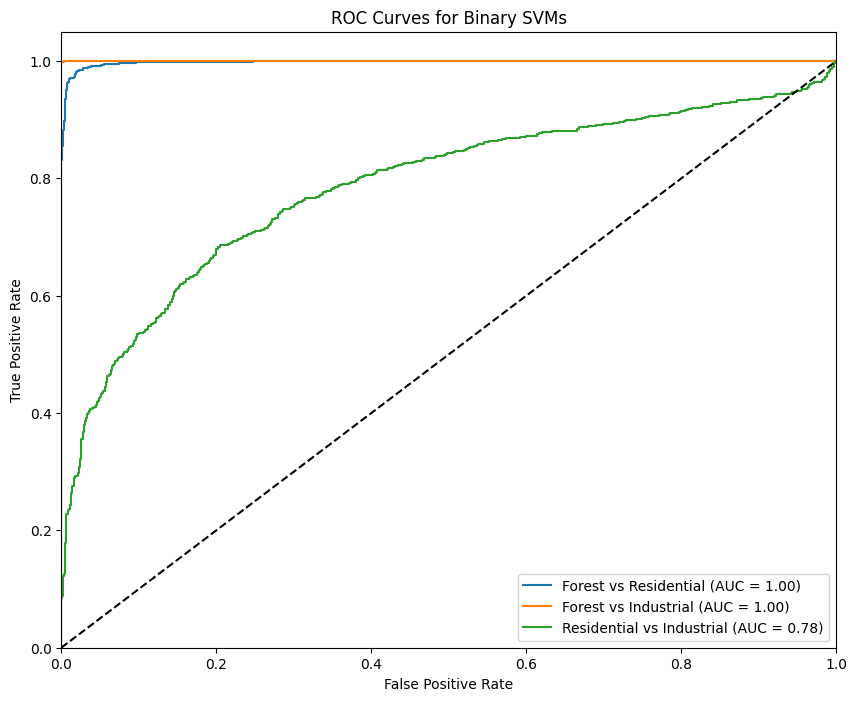

Accuracy for Forest vs Residential: 0.9688
AUC for Forest vs Residential: 0.9982
Accuracy for Forest vs Industrial: 0.9950
AUC for Forest vs Industrial: 1.0000
Accuracy for Residential vs Industrial: 0.7405
AUC for Residential vs Industrial: 0.7849


In [12]:

def train_binary_svm(X_train, y_train, X_test, y_test, class1, class2):

    binary_mask_train = np.isin(y_train, [class1, class2])
    binary_mask_test = np.isin(y_test, [class1, class2])

    X_train_binary = X_train[binary_mask_train]
    X_test_binary = X_test[binary_mask_test]
    y_train_binary = y_train[binary_mask_train]
    y_test_binary = y_test[binary_mask_test]

    y_train_binary = np.where(y_train_binary == class1, 0, 1)
    y_test_binary = np.where(y_test_binary == class1, 0, 1)

    sample_size = min(1000, len(X_train_binary))
    sample_indices = np.random.choice(len(X_train_binary), sample_size, replace=False)
    X_train_sample = X_train_binary[sample_indices]
    y_train_sample = y_train_binary[sample_indices]


    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train_sample, y_train_sample)

    y_pred = svm.predict(X_test_binary)
    accuracy = accuracy_score(y_test_binary, y_pred)

    y_scores = svm.decision_function(X_test_binary)
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    misclassified_indices = np.where(y_pred != y_test_binary)[0]

    return svm, accuracy, fpr, tpr, roc_auc, X_test_binary, y_test_binary, y_pred, misclassified_indices

 # Forest vs Residential, Forest vs Industrial, Residential vs Industrial
class_pairs = [(0, 1), (0, 2), (1, 2)]
class_pair_names = [
    ('Forest', 'Residential'),
    ('Forest', 'Industrial'),
    ('Residential', 'Industrial')
]

binary_svms = []
accuracies = []
fprs = []
tprs = []
aucs = []
misclassified_data = []

plt.figure(figsize=(10, 8))
for i, (class1, class2) in enumerate(class_pairs):
    print(f"Training SVM for {class_pair_names[i][0]} vs {class_pair_names[i][1]}...")
    svm, accuracy, fpr, tpr, roc_auc, X_test_binary, y_test_binary, y_pred, misclassified_indices = train_binary_svm(
        X_gray_train_subset, y_train_subset_mapped,
        X_gray_test_subset, y_test_subset_mapped,
        class1, class2
    )

    binary_svms.append(svm)
    accuracies.append(accuracy)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    misclassified_data.append((X_test_binary, y_test_binary, y_pred, misclassified_indices))

    plt.plot(fpr, tpr, label=f'{class_pair_names[i][0]} vs {class_pair_names[i][1]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary SVMs')
plt.legend(loc="lower right")
plt.show()

for i, pair_name in enumerate(class_pair_names):
    print(f"Accuracy for {pair_name[0]} vs {pair_name[1]}: {accuracies[i]:.4f}")
    print(f"AUC for {pair_name[0]} vs {pair_name[1]}: {aucs[i]:.4f}")

In [13]:

def majority_vote_svm(X, binary_svms, class_pairs):
    n_samples = X.shape[0]
    votes = np.zeros((n_samples, 3))

    for i, (class1, class2) in enumerate(class_pairs):

        binary_preds = binary_svms[i].predict(X)

        for j, pred in enumerate(binary_preds):
            if pred == 0:
                votes[j, class1] += 1
            else:
                votes[j, class2] += 1

    return np.argmax(votes, axis=1)

majority_preds = majority_vote_svm(X_gray_test_subset, binary_svms, class_pairs)
majority_accuracy = accuracy_score(y_test_subset_mapped, majority_preds)
print(f"Accuracy of majority-vote SVM: {majority_accuracy:.4f}")

Accuracy of majority-vote SVM: 0.8103


Accuracy of Random Forest: 0.9147


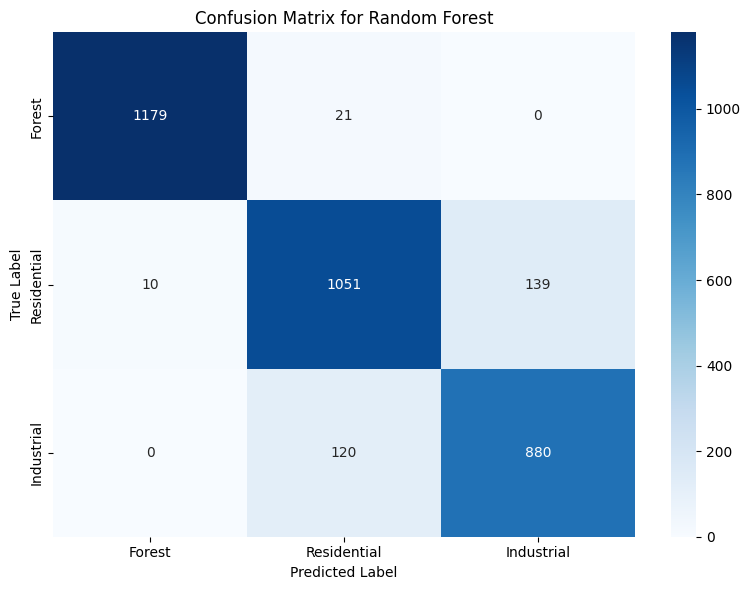

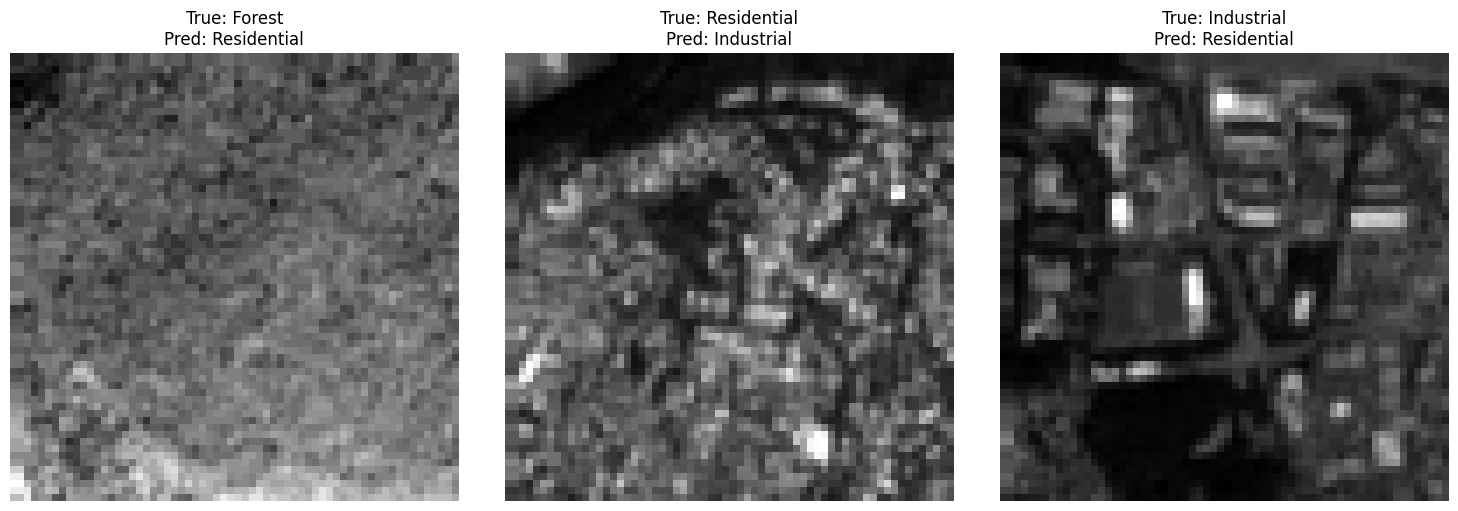

In [14]:

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_gray_train_subset, y_train_subset_mapped)
y_pred_rf = rf.predict(X_gray_test_subset)
accuracy_rf = accuracy_score(y_test_subset_mapped, y_pred_rf)
print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")

cm = confusion_matrix(y_test_subset_mapped, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_class_names, yticklabels=selected_class_names)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, class_idx in enumerate([0, 1, 2]):

    class_misclassified = np.where((y_test_subset_mapped == class_idx) &
                                  (y_pred_rf != class_idx))[0]

    if len(class_misclassified) > 0:
        idx = class_misclassified[0]
        img = X_gray_test_subset[idx].reshape(64, 64)
        true_label = selected_class_names[class_idx]
        pred_label = selected_class_names[y_pred_rf[idx]]

        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    else:
        plt.subplot(1, 3, i+1)
        plt.text(0.5, 0.5, f'No misclassifications for {selected_class_names[class_idx]}',
                ha='center', va='center')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:

print("Original images shape:", images.shape)
print("Original gray_images shape:", gray_images.shape)


images_train, images_test, gray_images_train, gray_images_test, y_train_dl, y_test_dl = train_test_split(
    images, gray_images, labels, test_size=0.4, stratify=labels, random_state=42
)

print("Training set shapes:")
print(f"RGB images: {images_train.shape}")
print(f"Grayscale images: {gray_images_train.shape}")
print(f"Labels: {y_train_dl.shape}")

print("\nTest set shapes:")
print(f"RGB images: {images_test.shape}")
print(f"Grayscale images: {gray_images_test.shape}")
print(f"Labels: {y_test_dl.shape}")

gray_images_train_reshaped = gray_images_train.reshape(-1, 64, 64, 1)
gray_images_test_reshaped = gray_images_test.reshape(-1, 64, 64, 1)

num_classes = len(class_names)
y_train_onehot = to_categorical(y_train_dl, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_dl, num_classes=num_classes)

print("\nReshaped dataset for deep learning:")
print(f"Grayscale training set shape: {gray_images_train_reshaped.shape}")
print(f"Grayscale testing set shape: {gray_images_test_reshaped.shape}")
print(f"One-hot encoded training labels shape: {y_train_onehot.shape}")
print(f"One-hot encoded testing labels shape: {y_test_onehot.shape}")

Original images shape: (27000, 64, 64, 3)
Original gray_images shape: (27000, 64, 64)
Training set shapes:
RGB images: (16200, 64, 64, 3)
Grayscale images: (16200, 64, 64)
Labels: (16200,)

Test set shapes:
RGB images: (10800, 64, 64, 3)
Grayscale images: (10800, 64, 64)
Labels: (10800,)

Reshaped dataset for deep learning:
Grayscale training set shape: (16200, 64, 64, 1)
Grayscale testing set shape: (10800, 64, 64, 1)
One-hot encoded training labels shape: (16200, 10)
One-hot encoded testing labels shape: (10800, 10)


In [18]:

model1 = Sequential([
    Flatten(input_shape=(64, 64, 1)),
    Dense(num_classes, activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

try:
    plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)
    from IPython.display import Image
    Image('model1.png')
except Exception as e:
    print(f"Could not visualize model: {e}")

history1 = model1.fit(
    gray_images_train_reshaped, y_train_onehot,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(gray_images_test_reshaped, y_test_onehot)
)

_, accuracy1 = model1.evaluate(gray_images_test_reshaped, y_test_onehot)
print(f"Model 1 Accuracy: {accuracy1:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,970 (160.04 KB)

 Trainable params: 40,970 (160.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1281 - loss: 2.3645 - val_accuracy: 0.1388 - val_loss: 2.3695
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1613 - loss: 2.2603 - val_accuracy: 0.1438 - val_loss: 2.3408
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1796 - loss: 2.2316 - val_accuracy: 0.1472 - val_loss: 2.3224
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1901 - loss: 2.2079 - val_accuracy: 0.1469 - val_loss: 2.3072
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2030 - loss: 2.1865 - val_accuracy: 0.1483 - val_loss: 2.2939
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2136 - loss: 2.1667 - val_accuracy: 0.1569 - val_loss: 2.2821
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2283 - loss: 2.1483 - val_accuracy: 0.1748 - val_loss: 2.2715
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2380 - loss: 2.1312 - val_accuracy: 0

In [19]:

model2 = Sequential([
    Flatten(input_shape=(64, 64, 1)),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

try:
    plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)
    from IPython.display import Image
    Image('model2.png')
except Exception as e:
    print(f"Could not visualize model: {e}")

history2 = model2.fit(
    gray_images_train_reshaped, y_train_onehot,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(gray_images_test_reshaped, y_test_onehot)
)

_, accuracy2 = model2.evaluate(gray_images_test_reshaped, y_test_onehot)
print(f"Model 2 Accuracy: {accuracy2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,706 (2.01 MB)

 Trainable params: 525,706 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1191 - loss: 2.4005 - val_accuracy: 0.1521 - val_loss: 2.2216
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1462 - loss: 2.1973 - val_accuracy: 0.1986 - val_loss: 2.1545
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1949 - loss: 2.1441 - val_accuracy: 0.2419 - val_loss: 2.1248
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2295 - loss: 2.1098 - val_accuracy: 0.2559 - val_loss: 2.0820
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2461 - loss: 2.0740 - val_accuracy: 0.2925 - val_loss: 2.0592
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2621 - loss: 2.0458 - val_accuracy: 0.2926 - val_loss: 2.0258
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2740 - loss: 2.0165 - val_accuracy: 0.2934 - val_loss: 2.0065
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2857 - loss: 1.9886 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,090,634 (4.16 MB)

 Trainable params: 1,090,634 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.1009 - loss: 2.3603 - val_accuracy: 0.1111 - val_loss: 2.2961
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1105 - loss: 2.2905 - val_accuracy: 0.1111 - val_loss: 2.2956
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1031 - loss: 2.2961 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1094 - loss: 2.2951 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1111 - loss: 2.2954 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1073 - loss: 2.2950 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1090 - loss: 2.2951 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1055 - loss: 2.2952 - val_accuracy: 

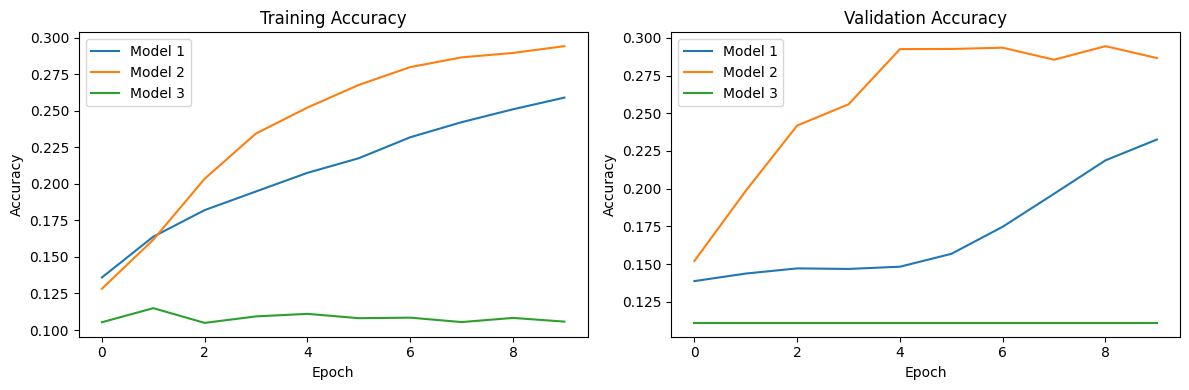

In [20]:
model3 = Sequential([
    Flatten(input_shape=(64, 64, 1)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

# Train the model
history3 = model3.fit(
    gray_images_train_reshaped, y_train_onehot,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(gray_images_test_reshaped, y_test_onehot)
)

# Evaluate the model
_, accuracy3 = model3.evaluate(gray_images_test_reshaped, y_test_onehot)
print(f"Model 3 Accuracy: {accuracy3:.4f}")

# Model Comparison
print("Parameters in Model 1:", model1.count_params())
print("Parameters in Model 2:", model2.count_params())
print("Parameters in Model 3:", model3.count_params())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1')
plt.plot(history2.history['accuracy'], label='Model 2')
plt.plot(history3.history['accuracy'], label='Model 3')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_accuracy'], label='Model 1')
plt.plot(history2.history['val_accuracy'], label='Model 2')
plt.plot(history3.history['val_accuracy'], label='Model 3')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

# Train the model
history4 = model4.fit(
    images_train, y_train_onehot,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(images_test, y_test_onehot)
)

# Evaluate the model
_, accuracy4 = model4.evaluate(images_test, y_test_onehot)
print(f"Model 4 Accuracy: {accuracy4:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,143,242 (4.36 MB)

 Trainable params: 1,143,242 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3444 - loss: 1.7092 - val_accuracy: 0.6362 - val_loss: 0.9890
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6226 - loss: 1.0320 - val_accuracy: 0.7287 - val_loss: 0.7656
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7023 - loss: 0.8453 - val_accuracy: 0.7482 - val_loss: 0.6841
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7307 - loss: 0.7518 - val_accuracy: 0.7692 - val_loss: 0.6242
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7636 - loss: 0.6607 - val_accuracy: 0.7331 - val_loss: 0.7116
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7756 - loss: 0.6387 - val_accuracy: 0.8035 - val_loss: 0.5479
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7916 - loss: 0.5800 - val_accuracy: 0.8005 - val_loss: 0.5577
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7977 - loss: 0.5691 - val_accuracy: 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,241,802 (58.14 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6987 - loss: 2.4717 - val_accuracy: 0.8771 - val_loss: 0.4018
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8555 - loss: 0.4672 - val_accuracy: 0.8913 - val_loss: 0.3576
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8944 - loss: 0.3307 - val_accuracy: 0.9026 - val_loss: 0.3234
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9135 - loss: 0.2689 - val_accuracy: 0.9098 - val_loss: 0.3337
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9237 - loss: 0.2441 - val_accuracy: 0.9085 - val_loss: 0.3310
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9331 - loss: 0.2055 - val_accuracy: 0.9086 - val_loss: 0.3776
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9076 - loss: 0.3202
Model 5 Accuracy: 0.9026

Model Accuracy Comparison:
Model 1 (Simple FC): 0.2326
Model 2 (FC with 1 hidden layer): 0.2866
Model 3 (FC with dropout): 0.1111

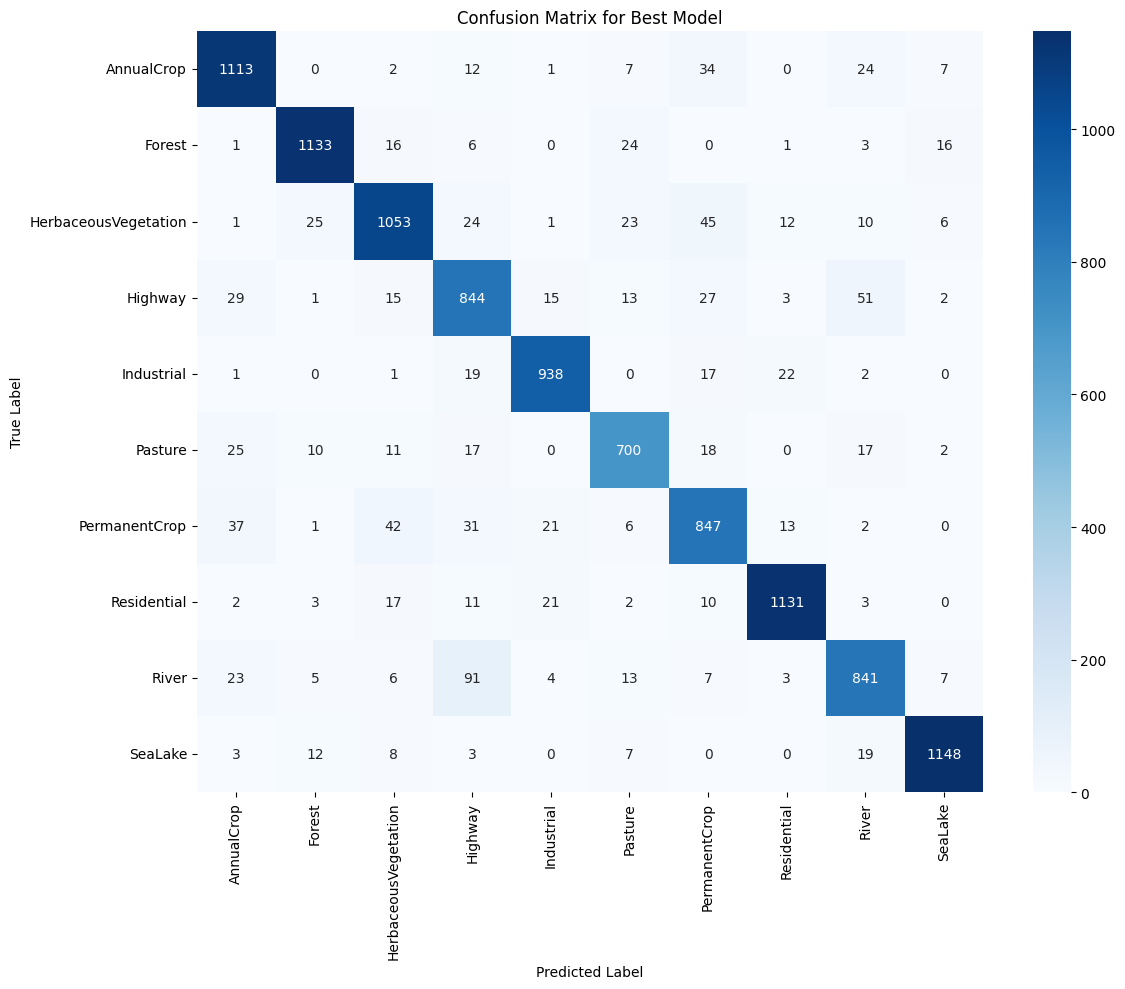

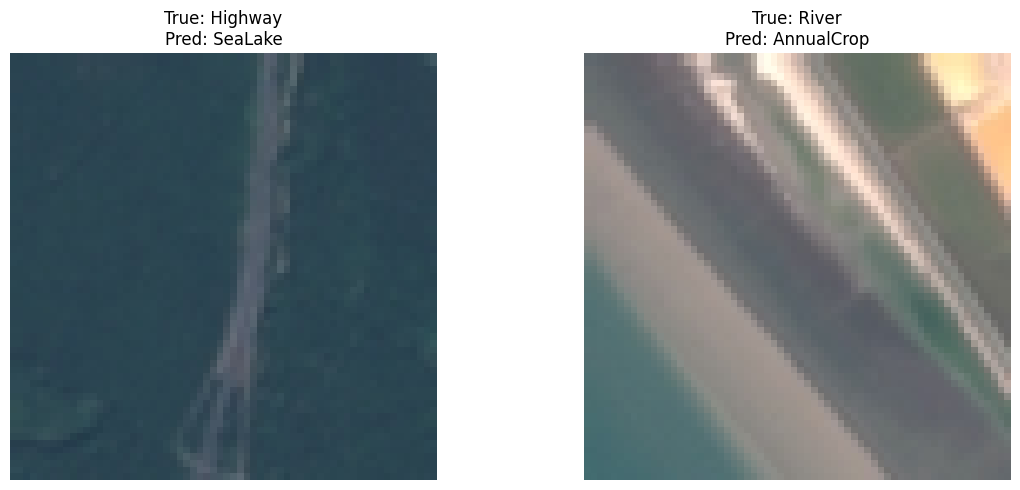

In [22]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

images_train_preprocessed = preprocess_input(images_train * 255)  # VGG16 expects 0-255 range
images_test_preprocessed = preprocess_input(images_test * 255)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model5 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history5 = model5.fit(
    images_train_preprocessed, y_train_onehot,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(images_test_preprocessed, y_test_onehot),
    callbacks=[early_stopping]
)


_, accuracy5 = model5.evaluate(images_test_preprocessed, y_test_onehot)
print(f"Model 5 Accuracy: {accuracy5:.4f}")

print("\nModel Accuracy Comparison:")
print(f"Model 1 (Simple FC): {accuracy1:.4f}")
print(f"Model 2 (FC with 1 hidden layer): {accuracy2:.4f}")
print(f"Model 3 (FC with dropout): {accuracy3:.4f}")
print(f"Model 4 (CNN): {accuracy4:.4f}")
print(f"Model 5 (Transfer Learning): {accuracy5:.4f}")

best_model = model5
best_model_preds = best_model.predict(images_test_preprocessed)
y_pred_classes = np.argmax(best_model_preds, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)


cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracies = np.diag(cm_normalized)
error_rates = 1 - class_accuracies

worst_classes_idx = np.argsort(error_rates)[-2:]
worst_classes = [class_names[i] for i in worst_classes_idx]

print(f"\nThe two classes with highest error rates are: {worst_classes[1]} and {worst_classes[0]}")
print(f"Error rates: {error_rates[worst_classes_idx[1]]:.4f} and {error_rates[worst_classes_idx[0]]:.4f}")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for i, class_idx in enumerate(worst_classes_idx):
    misclassified = np.where((y_true_classes == class_idx) & (y_pred_classes != class_idx))[0]
    if len(misclassified) > 0:
        idx = misclassified[0]
        plt.subplot(1, 2, i+1)
        plt.imshow(images_test[idx])
        plt.title(f'True: {class_names[class_idx]}\nPred: {class_names[y_pred_classes[idx]]}')
        plt.axis('off')
plt.tight_layout()
plt.show()